In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
Last_12 = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(Last_12)

('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,Measurement.prcp).\
          filter(Measurement.date > one_year_ago).\
         order_by(Measurement.date).all()
#Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df.head()
# Sort the dataframe by date
prcp_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<Figure size 432x360 with 0 Axes>

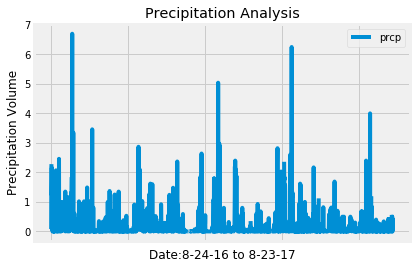

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(6,5))
prcp_df.plot('date','prcp')
plt.grid(True)
plt.xlabel("Date:8-24-16 to 8-23-17")
plt.ylabel("Precipitation Volume")
plt.title("Precipitation Analysis")
plt.legend()
plt.savefig("Precipitation_Analysis.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_data = session.query(Measurement).group_by(Measurement.station).count()
print(station_data)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_tobs, max_tobs, avg_tobs = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == active_stations[0][0]).\
                         one()
print(f"The minimum Temperature at {active_stations[0][0]} is {min_tobs}")
print(f"The maximum Temperature at {active_stations[0][0]} is {max_tobs}")
print(f"The average Temperature at  {active_stations[0][0]} is {avg_tobs}")

The minimum Temperature at USC00519281 is 54.0
The maximum Temperature at USC00519281 is 85.0
The average Temperature at  USC00519281 is 71.66378066378067


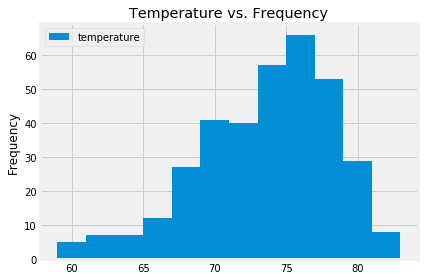

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
temps_station= temps_station[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

temperature_observations.plot.hist(bins=12,title="Temperature vs. Frequency")
plt.tight_layout()
#plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()
#plot the results as a histogram




In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


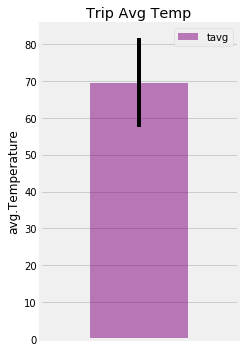

In [21]:
# Plot the results from your previous query as a bar chart. 
trip = calc_temps('2012-02-28','2012-03-05')
trip
calc_temp = pd.DataFrame(trip, columns=['tmin','tavg','tmax'])
# Use "Trip Avg Temp" as your Title
calc_temp.plot.bar(y='tavg', yerr=(calc_temp['tmax'] - calc_temp['tmin']), title='Trip Avg Temp', color='purple', alpha=0.5, figsize=(3.5,5))
plt.xticks(np.arange(0, 0))
plt.ylabel("avg.Temperature")
plt.tight_layout()
plt.savefig("Trip_avg_temp.png")
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



rainfall=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,\
                       func.sum(Measurement.prcp)).\
filter(Measurement.station==Station.station).\
filter(Measurement.date >= prev_year_start).filter(Measurement.date <= prev_year_start).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_df=pd.DataFrame(rainfall,columns=["station","name","latitude","longitude","elevation","precipitation"])
rainfall_df

,station,name,latitude,longitude,elevation,precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.29
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.03
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.03
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,NaN


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
start = dt.datetime.strptime("2018-03-05", "%Y-%m-%d")
end = dt.datetime.strptime("2018-03-10", "%Y-%m-%d")
dates=[]
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]


# Loop through the list of %m-%d strings and calculate the normals for each date

for date in date_generated:
    dates.append(date.strftime("%m-%d"))
for day in dates:
    print(daily_normals(day))




[(60.0, 67.89090909090909, 76.0)]
[(60.0, 69.20338983050847, 76.0)]
[(60.0, 69.17241379310344, 78.0)]
[(59.0, 68.72413793103448, 78.0)]
[(57.0, 68.56140350877193, 75.0)]


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_date=[]
for date in date_generated:
    trip_date.append(date.strftime("%Y-%m-%d"))
daily=[]
for day in dates:
    daily_normal={}
    daily_normal["tmin"]=daily_normals(day)[0][0]
    daily_normal["tavg"]=daily_normals(day)[0][1]
    daily_normal["tmax"]=daily_normals(day)[0][2]
    daily.append(daily_normal)
daily_df=pd.DataFrame(daily)
daily_df["date"]=trip_date
daily_df.set_index("date",inplace=True)
daily_df

,tavg,tmax,tmin
date,,,
2018-03-05,67.890909,76.0,60.0
2018-03-06,69.203390,76.0,60.0
2018-03-07,69.172414,78.0,60.0
2018-03-08,68.724138,78.0,59.0
2018-03-09,68.561404,75.0,57.0


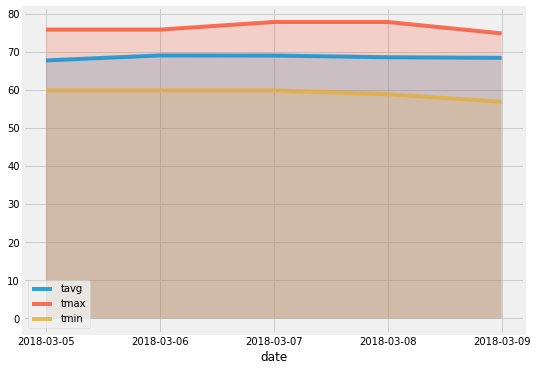

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind="line",stacked=False,alpha=0.8,figsize=(8,6))
plt.fill_between(daily_df.index,daily_df["tavg"],alpha=0.2)
plt.fill_between(daily_df.index,daily_df["tmax"],alpha=0.2)
plt.fill_between(daily_df.index,daily_df["tmin"],alpha=0.2)
xlocation=[x for x in daily_df.index]
plt.xticks(xlocation,daily_df.index)
plt.savefig("daily_normal.png")
plt.show()